In [37]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
from util.team_strength_team_stats import calculate_team_stats, calculate_chances_from_played_games, create_test_dataset_entry_based_on_certain_matchweeks, generate_dataset, create_home_away_pairs
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nuanced Team Strength Model

### Legend:  
🔴- to do <br>
🟠- in progress <br>
🟢- done <br>


### Used Features to quantify Team Strength:
- 🟢 Possession
- 🟢 Shots on Goal/ 🔴 on Target
- 🟢 Goals 
- 🟢 Goals_conceded
- 🟢 X_Goals
- 🟢 Passes 
- 🟠 Duels


### Other Features used to predict Match Outcomes:
- 🔴 Last 5 matches
- 🟢 Starting XI


### Output Predictions
- 🔴 Label of Match Status for Home Team
- 🔴 Betting Odds for both Home and Away Team

### Trainings/Test Daten
<br>


### Prior Baseline (Aus Literatur Outcome Prediction Modelle anschauen)


# Event Types, etc.

In [38]:
# Load data
matches = load_matches(competition_id=9, season_id=27)

test_event = sb.events(match_id=3890259)
test_event.shape

print('------------distinct_types----------------')
print(test_event['type'].unique())
print('------------pass_outcome----------------')
print(test_event['pass_outcome'].unique())
print('------------pass_type-------------')
print(test_event['pass_type'].unique())
print('------------pass_height----------------')
print(test_event['pass_height'].unique())

------------distinct_types----------------
['Starting XI' 'Half Start' 'Pass' 'Pressure' 'Ball Receipt*' 'Carry'
 'Duel' 'Clearance' 'Ball Recovery' 'Interception' 'Dispossessed'
 'Miscontrol' 'Block' 'Foul Committed' 'Foul Won' 'Shot' 'Goal Keeper'
 'Shield' '50/50' 'Dribble' 'Dribbled Past' 'Injury Stoppage' 'Player Off'
 'Player On' 'Half End' 'Error' 'Substitution' 'Tactical Shift']
------------pass_outcome----------------
[nan 'Incomplete' 'Out' 'Unknown' 'Pass Offside']
------------pass_type-------------
[nan 'Kick Off' 'Throw-in' 'Recovery' 'Free Kick' 'Goal Kick' 'Corner'
 'Interception']
------------pass_height----------------
[nan 'Ground Pass' 'High Pass' 'Low Pass']


# Getting the informations out of the event dataframes

## Single Match ( First Game of Bundesliga Season 15/16)

In [39]:
team_stats = calculate_team_stats(event=test_event)
team_stats

,team,completed_passes,total_passes,pass_completion_percentage,Shots,duels,xG,Goals,Goals Conceded,Possession
0,Bayern Munich,711,797,89.209536,22,76,2.24,5.0,0.0,78.0
1,Hamburger SV,150,240,62.500000,5,76,0.08,0.0,5.0,22.0


## All Matches of Bundesliga Season 15/16
The following Code takes long to execute, since its pulling the data from the statsbomb API (therefore its written locally in a csv file)

In [40]:
'''
all_team_stats = []
for _, match in matches.iterrows(): 
   match_id = match['match_id'] 
   match_date = match['match_date']
   match_week = match['match_week']
   #print(f'Start gathering Information from Match_ID = {match_id}')
   match_stats = calculate_team_stats(sb.events(match_id=match_id))
   match_stats['match_id'] = match_id
   match_stats['match_date'] = match_date
   match_stats['match_week'] = match_week
   all_team_stats.append(match_stats)
#   match_day += 1

team_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
team_stats.to_csv('./Data/team_strength_stats.csv')
'''

"\nall_team_stats = []\nfor _, match in matches.iterrows(): \n   match_id = match['match_id'] \n   match_date = match['match_date']\n   match_week = match['match_week']\n   #print(f'Start gathering Information from Match_ID = {match_id}')\n   match_stats = calculate_team_stats(sb.events(match_id=match_id))\n   match_stats['match_id'] = match_id\n   match_stats['match_date'] = match_date\n   match_stats['match_week'] = match_week\n   all_team_stats.append(match_stats)\n#   match_day += 1\n\nteam_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')\nteam_stats.to_csv('./Data/team_strength_stats.csv')\n"

## Now in the Dataframe Team_Stats is every Stat for every Team for every Match

In [41]:
team_stats = pd.read_csv('./Data/team_strength_stats.csv')
team_stats['match_date'] = pd.to_datetime(team_stats['match_date'])
team_stats.sort_values('match_date')


#For example get the average pass completion percentage
team_stats.groupby(['team'])['pass_completion_percentage'].mean().reset_index(name='avg_pass_completion_percentage').sort_values('avg_pass_completion_percentage', ascending=False).head(20)

,team,avg_pass_completion_percentage
2,Bayern Munich,86.538269
3,Borussia Dortmund,82.751210
17,Wolfsburg,81.192701
4,Borussia Mönchengladbach,79.465608
14,Schalke 04,78.534258
11,Hertha Berlin,77.500490
0,Augsburg,74.321272
7,FC Köln,73.537738
1,Bayer Leverkusen,72.752820
12,Hoffenheim,72.739057


In [42]:

chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, 35)), round_decimals=None)
home_team = 'Bayern Munich'
away_team = 'Borussia Dortmund'
# This function creates a single entry which contains the stats of the teams, based on certain matchweeks and assigns the actual game result
single_datapoint = create_test_dataset_entry_based_on_certain_matchweeks(home_team=home_team, away_team=away_team, chances=chances, matches=matches)

In [43]:
train_dataset = generate_dataset(team_stats=team_stats, matches=matches, amount_of_weeks_to_simulate=100)


In [44]:
X = train_dataset.drop(columns=['actual_result'])  # All columns except the target
y = train_dataset['actual_result']  # Just the target column

# Initial split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Define preprocessing
categorical_features = ['home_team', 'away_team']
numerical_features = X_train.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

# 3. Apply preprocessing SEPARATELY to train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # Important: use transform(), not fit_transform()

# Verify shapes
print(f"Train features: {X_train_processed.shape}, Train labels: {y_train.shape}")
print(f"Test features: {X_test_processed.shape}, Test labels: {y_test.shape}")


Train features: (720, 48), Train labels: (720,)
Test features: (180, 48), Test labels: (180,)


              precision    recall  f1-score   support

        Draw       0.65      0.40      0.50        42
 Home_Defeat       0.67      0.81      0.73        58
Home_Victory       0.79      0.82      0.80        80

    accuracy                           0.72       180
   macro avg       0.70      0.68      0.68       180
weighted avg       0.72      0.72      0.71       180



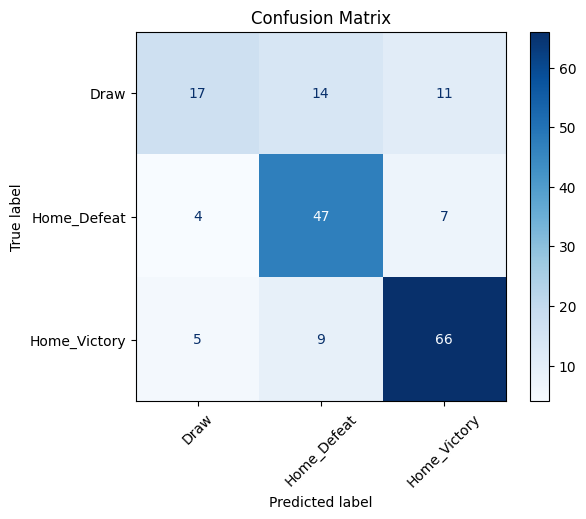

In [45]:
model = RandomForestClassifier(n_estimators=400)
model.fit(X_train_processed, y_train)

predictions = model.predict(X_test_processed)

print(
    classification_report(
        y_test,          # True labels (strings)
        predictions,          # Predicted labels (strings)
        target_names=['Draw', 'Home_Defeat', 'Home_Victory']  # Optional: ensures consistent order
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    predictions,
    display_labels=['Draw', 'Home_Defeat', 'Home_Victory'],
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.show()

In [46]:
probabilities_array = model.predict_proba(X_test_processed)
probabilities_array.shape  #'Draw', 'Home_Defeat', 'Home_Victory'

x_probabilities = pd.DataFrame(
    data=probabilities_array,
    columns=['Draw', 'Home_Defeat', 'Home_Victory'],
    index=X_test.index
)
x_probabilities = x_probabilities.add_prefix('predicted_')

y_test_proba = pd.get_dummies(y_test, dtype='float64')
y_test_proba = y_test_proba.add_prefix('actual_')

prediction_and_outcome = pd.merge(x_probabilities, y_test_proba, left_index=True, right_index=True)
prediction_and_outcome.columns


predicted = prediction_and_outcome[['predicted_Draw', 'predicted_Home_Defeat', 'predicted_Home_Victory']].values
actual = prediction_and_outcome[['actual_Draw', 'actual_Home_Defeat', 'actual_Home_Victory']].values

brier_score = np.mean(np.sum((predicted - actual) ** 2, axis=1))
print(brier_score)

0.39744986111111114


# Gathering some infomation about Teams

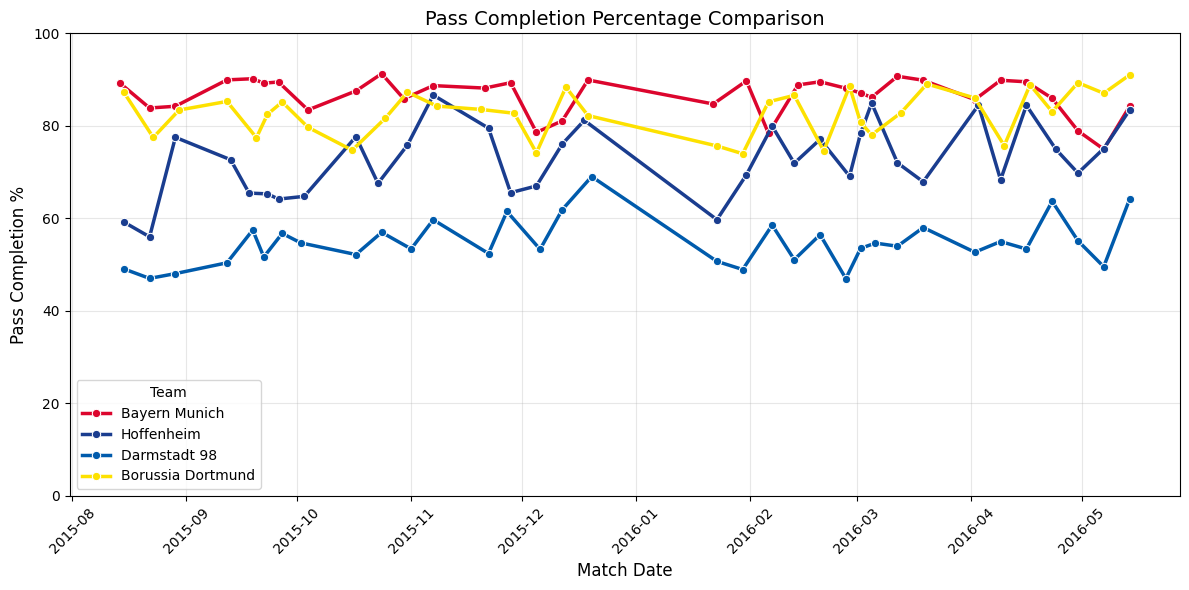

In [47]:
pass_completion_rates = team_stats[['team', 'match_date', 'pass_completion_percentage']]

teams_to_plot = ['Bayern Munich', 'Borussia Dortmund', 'Darmstadt 98', 'Hoffenheim']
multi_team_data = pass_completion_rates[pass_completion_rates['team'].isin(teams_to_plot)]


custom_colors = {
    'Bayern Munich': '#DC052D',        # Red
    'Borussia Dortmund': '#FDE100',    # Yellow
    'Darmstadt 98': '#005BAC',         # Blue
    'Hoffenheim': '#1A3D8F'            # Dark Blue
}
# Create plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=multi_team_data,
             x='match_date',
             y='pass_completion_percentage',
             hue='team',
             marker='o',
             palette= custom_colors,
             linewidth=2.5)

plt.title('Pass Completion Percentage Comparison', fontsize=14)
plt.xlabel('Match Date', fontsize=12)
plt.ylabel('Pass Completion %', fontsize=12)
plt.legend(title='Team')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()